In [1]:
! pip install networkx
! pip install plotly
! pip install colorlover
! pip install NRCLex

     |████████████████████████████████| 399kB 5.6MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-cp36-none-any.whl size=43313 sha256=25b84ff3adc0071ddea7aab0c64d1ebfc14df8cf31be233fc541000d58de34a6
  Stored in directory: /root/.cache/pip/wheels/17/31/64/035a8d245b4c217aeb8e8a2702d05dc91544b9c2334db72414
Successfully built NRCLex


In [72]:
import networkx as nx

import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)

import colorlover as cl
from IPython.display import HTML

import heapq
import random
import operator

from nrclex import NRCLex #not just the sentiment, but the emotion (word counting based)
import re
import nltk
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt')

from IPython.display import Image

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Q1. Choose a hash-tag

* Hash-tag: #wordpress
* Dataset: tweets2009-06-0115.csv.zip

* I completed the user study twice (in 2 different scenarios) on Dec 4 at 5:54pm and 6:21pm using username: stuart.xu@mail.utoronto.ca



# Q2. Build a Mention Graph

### (a) How many nodes and how many edges are in your mention graph?

In [3]:
df = pd.read_csv("tweets2009-06-0115.csv.zip", sep='\t',compression='zip')

In [4]:
print("Num of rows:", df.shape[0])

Num of rows: 3437690


In [5]:
df.head()

date        user          tweet
0  2009-06-01 21:43:59  burtonator  No Post Title
1  2009-06-01 21:47:23  burtonator  No Post Title
2  2009-06-02 01:15:44  burtonator  No Post Title
3  2009-06-02 05:17:52  burtonator  No Post Title
4  2009-06-02 23:58:25  burtonator  No Post Title

In [6]:
# make a new dataframe just with our hashtag
#We want to see that a user mentioned other people in the tweets with this hash-tag
wordpressTag = df[df["tweet"].str.lower().str.contains("#wordpress", na=False)].copy()

In [7]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        #@ means directed to someone else in twitter
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
        
    #added a column of who is mentioned in the tweets
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [8]:
addMentionedColumn(wordpressTag)

In [9]:
wordpressTag

date  ...                 mentioned
11178    2009-06-11 17:13:37  ...                        []
11429    2009-06-11 17:13:49  ...             [spicydesign]
18214    2009-06-11 17:22:52  ...        [weblittlepieces)]
23141    2009-06-11 17:30:52  ...                        []
26453    2009-06-11 17:35:59  ...  [iblend, webdesign_news]
...                      ...  ...                       ...
3372572  2009-06-14 22:29:07  ...                        []
3395774  2009-06-14 22:59:08  ...               [ladyrasta]
3418003  2009-06-14 23:31:46  ...                        []
3425922  2009-06-14 23:43:14  ...             [barrymadden]
3431061  2009-06-14 23:50:36  ...                  [imanto]

[678 rows x 4 columns]

In [10]:
# for all the tweets with your hashtag, build the mention graph, build connection btn the user and mentioned users
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [11]:
wordpressGraph = mentionGraph(wordpressTag)

In [12]:
print("# nodes:", len(wordpressGraph.nodes()))
print("# edges:", len(wordpressGraph.edges()))

# nodes: 413
# edges: 366


* Number of nodes: 413
* Number of edges: 366

### (b) Build a histogram of the graph nodes’ degree (i.e., the degree distribution of the graph). What does the distribution in node degree tell you about how your network is structured?

In [13]:
degree_list = []
for node in wordpressGraph.nodes():
    degree = nx.degree(wordpressGraph, node)
    degree_list.append(degree)

In [14]:
fig = go.Figure(data=[go.Histogram(x = degree_list, opacity=0.8)])
fig.update_layout(
    title_text="Histogram of the graph nodes'degree",
    xaxis_title_text="Nodes'degree",
    yaxis_title_text="Frequency", 
    bargap=0.2,
    bargroupgap=0.2
)
fig.show(renderer="colab")

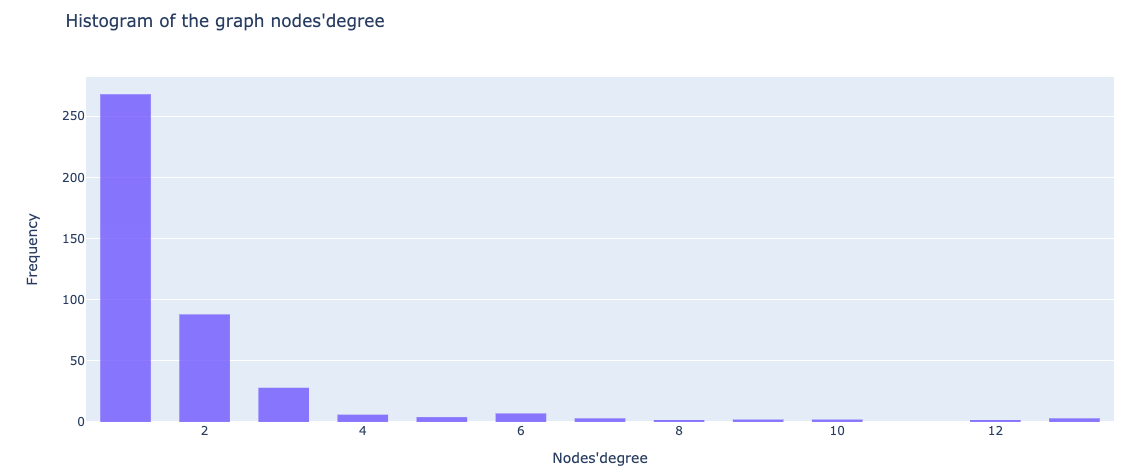

In [73]:
Image('Q2_b.png')

* This histogram tells us a large fraction (about 93%) of the nodes have 1 to 3 degrees. Which means most users only mention the other users 1 to 3 times by each other with the hashtag #wordpress. About 65% of nodes have 1 degrees. Which means the users do not interact with eachother very often. Some nodes have more than 10 degrees which indicates these user accounts or the mentioned users accounts are probably robots which can generate tweets automatically with this hastag, or just someone active who intentionally mention others due to personal or business interest.

### (c) Build a log-log scatterplot with the node degree (x-axis) and fraction of nodes with that degree (y-axis). Does your mention graph exhibit a power law trend? If not, can you explain why that may be?

In [15]:
scatter_x = list(set(degree_list))
degree_frequency = Counter(degree_list)
scatter_y = []
for degree in scatter_x:
    y_fraction = degree_frequency[degree] / len(degree_list)
    scatter_y.append(y_fraction)

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=scatter_x, y=scatter_y))
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.update_layout(title_text="Log-log scatterplot",
                  xaxis_title_text="Nodes'degree",
                  yaxis_title_text="Fraction of nodes",
                  xaxis_type="log",
                  yaxis_type="log")
fig.show(renderer="colab")

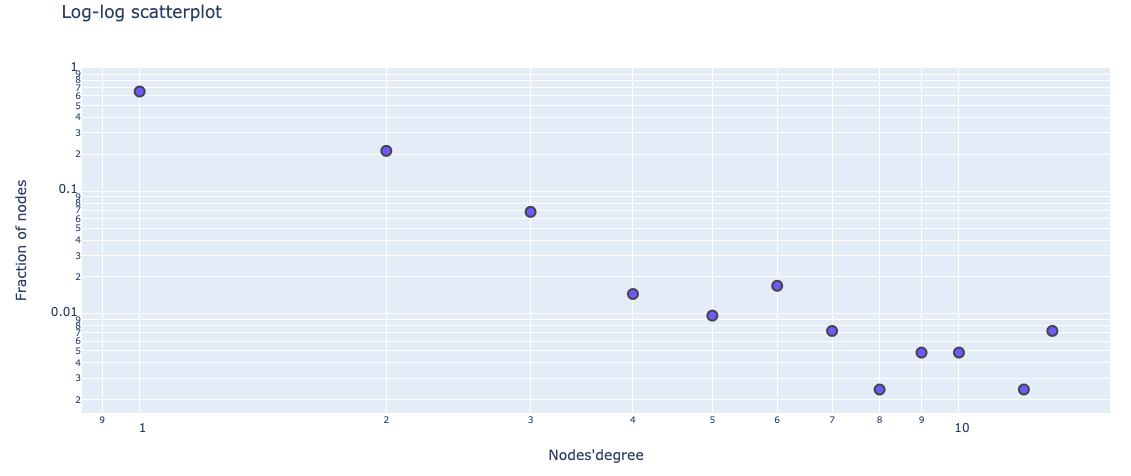

In [74]:
Image('Q2_c.png')

* This log-log scatterplot shows a linear trend, which indicates a definite power law trend where the slope of this trend shows the power of the relationship. If this is plotted in a normal linear plot, it will show a power trend with long tail distribution (the shape is similar to the first plot).

### (d) For the highest-weighted edge, list the tweets (up to 25) for that edge and describe the interaction between these two users which explains why this edge has the highest weight. Note: edges are identified be the two nodes they connect, e.g., ⟨node1, node2⟩.

In [17]:
edge_list = []
weight_list = []
for edge in wordpressGraph.edges():
    edge_list.append(edge)
    weight = wordpressGraph[edge[0]][edge[1]]['numberMentions']
    weight_list.append(weight)
numberMentions_df = pd.DataFrame(list(zip(edge_list, weight_list)), columns =['Edge', 'Number Mentions'])
numberMentions_df.sort_values(by=['Number Mentions'], ascending=False).head()

Edge  Number Mentions
170       (textimps, danielfelice)                3
273  (ruhanirabin, thefelixmolina)                3
41             (area1, robinmwood)                3
30     (hashwordpress, robinmwood)                3
51          (area1, bebopdesigner)                3

In [18]:
highest_weighted_df = wordpressTag[(wordpressTag['user']=='textimps') & (wordpressTag['mentioned'].str.join(',').str.contains('danielfelice'))
            |(wordpressTag['user']=='danielfelice') & (wordpressTag['mentioned'].str.join(',').str.contains('textimps'))]
pd.set_option('display.max_colwidth', None)
highest_weighted_df["tweet"]

912024      RT @danielfelice: 1 more day to vote!! BuddyPress Theme Contest! http://www.freebpthemes.com ! #wordpress #buddypress
2282461     RT @danielfelice: 1 more day to vote!! BuddyPress Theme Contest! http://www.freebpthemes.com ! #wordpress #buddypress
3309551    RT @danielfelice: not long left to vote! BuddyPress Theme Contest - http://www.freebpthemes.com #buddypress #wordpress
Name: tweet, dtype: object

* Serveral edges have the same maximum weight which is 3. Take an example using the first edge <textimps, danielfelice>. The tweets are shown above. We can see that these two users are probably friends while one user keeps asking another user to vote for a contest. This is the reason why it has the highest weight which indicates this contest might be very important to the user.

### (e) Provide a visualization of the mention graph in which the edges visually (e.g., color, weight, etc.) reflects its weight (i.e., the number of mentions). Note: Be sure to use layouts to help make the visualizations clear.

* NX Random layout is used to reduce overlapping edges and nodes.

In [19]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [20]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [21]:
addRandomPositions(wordpressGraph)

In [22]:
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [23]:
# map purd color scale to 4 cells
YlGn = cl.scales['4']['seq']['YlGn']
HTML(cl.to_html(YlGn))

In [24]:
def plotNetworkSizeColor(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=YlGn[edgeWidth]))
        scatters.append(s)

    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos],
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#FA8072", 
                    size=7,
                    line=dict(width=1)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=True)

In [25]:
#Use NX random layout
wordpressGraphRandom = wordpressGraph.copy()
applyLayout(wordpressGraphRandom, nx.random_layout)
configure_plotly_browser_state()
plotNetworkSizeColor(wordpressGraphRandom)

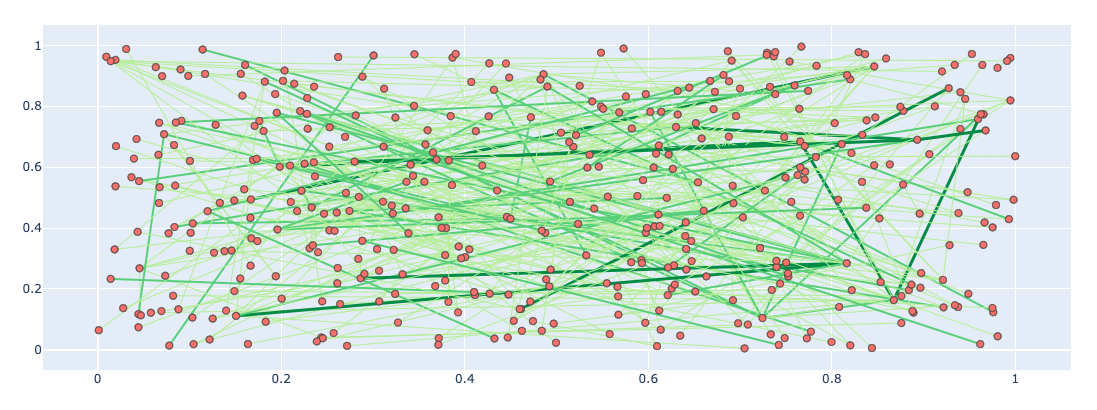

In [75]:
Image('Q2_e.png')

# Q3. Content Analysis

### (a) Analyze the most frequent non-stopwords in all the tweets with the chosen hash-tag, and provide a basic description of the main themes.

In [26]:
def getTopK(df, kwords):
    stop = set(stopwords.words('english'))
    counter = Counter()
    tweets = df['tweet'].values
    for tweet in tweets: 
        tweet_noURL = re.sub(r"http\S+", "", tweet)
        counter.update([word.lower() 
                        for word in re.findall(r'\w+', tweet_noURL)
                        if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords) 
    return topk

In [27]:
getTopK(wordpressTag, 30)

[('wordpress', 853),
 ('blog', 94),
 ('plugin', 54),
 ('plugins', 52),
 ('new', 52),
 ('via', 49),
 ('free', 49),
 ('theme', 48),
 ('2009', 47),
 ('site', 44),
 ('themes', 44),
 ('upgrade', 43),
 ('design', 41),
 ('need', 38),
 ('resources', 36),
 ('know', 33),
 ('things', 31),
 ('developers', 30),
 ('website', 27),
 ('tutorials', 25),
 ('hashwp', 24),
 ('web', 22),
 ('seo', 22),
 ('com', 20),
 ('update', 19),
 ('guide', 19),
 ('auf', 17),
 ('twitter', 17),
 ('like', 17),
 ('cool', 17)]

In [28]:
wordpressTag[wordpressTag['tweet'].str.lower().str.contains('blog')]['tweet'][:5]

11429                                                        RT @spicydesign: 10 Social Media #Plugins for your #WordPress Blog http://bit.ly/1JZKKi
26453                                    RT @iBlend: RT @webdesign_news: 10 Social Media #Plugins for your #WordPress Blog http://tinyurl.com/kl283c
27107     Taking your questions for our opening session at WordCamp Montréal with @photomatt - ask on the blog - http://bit.ly/wcmtl-matt #wordpress
108414               Liebe Blogger, #WordPress 2.8 ist da. Wir haben gerade geupdatet. Und ja, es funktioniert auf Anhieb. http://tinyurl.com/l4zndj
112988               Liebe Blogger, #WordPress 2.8 ist da. Wir haben gerade geupdatet. Und ja, es funktioniert auf Anhieb. http://tinyurl.com/l4zndj
Name: tweet, dtype: object

In [29]:
wordpressTag[wordpressTag['tweet'].str.lower().str.contains('|'.join(['plugin','plugins']))]['tweet'][:5]

11429                                            RT @spicydesign: 10 Social Media #Plugins for your #WordPress Blog http://bit.ly/1JZKKi
26453                        RT @iBlend: RT @webdesign_news: 10 Social Media #Plugins for your #WordPress Blog http://tinyurl.com/kl283c
115062    Did you upgrade to #wordpress 2.8 yet? If so check out http://is.gd/Z588 for a plugin that gives you nofollow/dofollow control
226667                                    #wp EasySeo | WordPress Plugin Releases for 06/02 | SEO2Blog (http://cli.gs/hgD7Hd) #wordpress
247237                                                             Essential Plugin: SEO Smart Links - http://cli.gs/7zV1d9 - #wordpress
Name: tweet, dtype: object

In [30]:
wordpressTag[wordpressTag['tweet'].str.lower().str.contains('new')]['tweet'][:5]

23141                                                                     New post on #wordpress filesystem abstraction and updates http://is.gd/Z06y
26453                                     RT @iBlend: RT @webdesign_news: 10 Social Media #Plugins for your #WordPress Blog http://tinyurl.com/kl283c
163002                   RT @stevensnell: RT @nathanrice: GREAT new resource for #wordpress news/tutorials/etc. aggregation. http://www.wptopics.com/
284209    RT @randyjensen #WordPress new feature request: Way to update multiple plugins at once...that would be amazing for people who have 30+ pl..
304745                                     Updating my #Wordpress blog. Not sure if it's WP 2.8, or the new theme that is making the site "snappier".
Name: tweet, dtype: object

In [31]:
wordpressTag[wordpressTag['tweet'].str.lower().str.contains('free')]['tweet'][:5]

135206    England's Great Attractions And Features - Free Informations, Article, Free Promotion, WordPress Blog #wordpress #blogs http://ow.ly/dzRj
347496            #wordpress Get BadBot-Killer v2 for FREE!!! Stop Bots From Scanning Your WordPress Blog - http://wordpresssecured.com/bot_sub.php
374321            #wordpress Create Website For Free: I have had a website up for a while and it was almost finished bec.. http://u.mavrev.com/a5vf
376453                                #wordpress Get BadBot-Killer v2 for FREE!!! Stop Bots From Scanning Your WordPress Blog - http://bit.ly/tY93x
423462                                                         RT @wpdimension 45 Best Free #WordPress Themes of All Time http://tinyurl.com/lbcdre
Name: tweet, dtype: object

* I removed the stopwords as well as all the URLs when getting the most frequent words since I saw there were lots of "www", "com", "http" in the frequent word list. By looking at the frequent words, we can find lots of words are features related to the hashtag #wordpress. Wordpress is an open-source content management system. Some of its important features include plugin architecture, and themes. Also it was created as a blog-publishing system and we can see that blog is also a frequent word, meaning probably many of these users use Wordpress to creating blogs. Also it is a free software and probably there were new features coming up at that time. All these make sense as they are related to Wordpress and users were discussing about this software.

### (b) In a visualization of the mention graph add hover information for the nodes which lists the 3 most common words for each user. Indicate the nodes that have no words visually. For those nodes that have words, are the words similar for connected users or are the words different? If not the same, do the words have similar themes?

In [32]:
def getTopK_byUser(df, kwords, user):
    operation=operator.eq
    stop = set(stopwords.words('english'))
    counter = Counter()
    tweets = df.loc[operation(df['user'],user)]['tweet']
    for tweet in tweets: 
        tweet_noURL = re.sub(r"http\S+", "", tweet)
        counter.update([word.lower() 
                        for word in re.findall(r'\w+', tweet_noURL)
                        if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    topk_words = [word[0] for word in topk]
    return topk_words

In [33]:
user_list = wordpressTag.user.unique()
top3_words_list = []
for user in user_list:
    top3_words = getTopK_byUser(wordpressTag, 3, user)
    top3_words_list.append(top3_words)

In [34]:
User_commonword_df = pd.DataFrame(list(zip(user_list, top3_words_list)), columns =['User', 'Most_Common_Words'])
User_commonword_df['Most_Common_Words'] = User_commonword_df['Most_Common_Words'].str.join(',')
User_commonword_df.head() #395 rows, 395 users

User             Most_Common_Words
0   frankstepanski                     wordpress
1  designresources      spicydesign,social,media
2         bbeazely  wordpress,available,download
3              ezs            new,post,wordpress
4        gopalraju  iblend,webdesign_news,social

In [35]:
RdGy = cl.scales['4']['div']['RdGy']
HTML(cl.to_html(RdGy))

In [36]:
def plotNetworkSizeColor_hoverinfo(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=YlGn[edgeWidth]))
        scatters.append(s)

    for node in graph.nodes():
        words = User_commonword_df.loc[User_commonword_df["User"] == node, "Most_Common_Words"].values
        if len(words) == 0:
            node_color = 3
        else:
            node_color = 0
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s <br> Top3_Words: %s <br>" % (node, words),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=RdGy[node_color], 
                    size=7,
                    line=dict(width=1)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=True)

In [37]:
#Use NX random layout
applyLayout(wordpressGraphRandom, nx.random_layout)
configure_plotly_browser_state()
plotNetworkSizeColor_hoverinfo(wordpressGraphRandom)

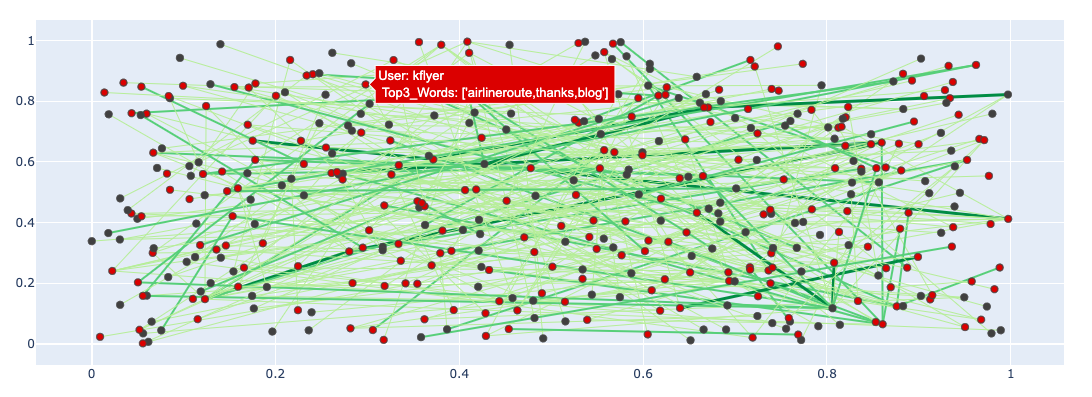

In [76]:
Image('Q3_b.png')

In [38]:
wordpressGraph.edges()

EdgeView([('designresources', 'spicydesign'), ('spicydesign', 'flowsionet'), ('spicydesign', 'krftd'), ('spicydesign', 'wpstudios'), ('spicydesign', '_miko'), ('spicydesign', 'dimensionmedia)'), ('spicydesign', 'jonasl'), ('spicydesign', 'objects'), ('spicydesign', 'aravindajith'), ('bbeazely', 'weblittlepieces)'), ('gopalraju', 'iblend'), ('gopalraju', 'webdesign_news'), ('iblend', 'pauloflaherty'), ('iblend', 'dlstl'), ('webdesign_news', 'thedesignmag'), ('webdesign_news', 'desimatlock'), ('webdesign_news', 'pauloflaherty'), ('webdesign_news', 'dlstl'), ('webdesign_news', 'reeph'), ('afrognthevalley', 'photomatt'), ('photomatt', 'full_throttle'), ('dahowlett', 'pauloflaherty'), ('bnotw', 'vincentabry'), ('pauloelias', ''), ('', 'lindaalexandra'), ('', 'craigtooms'), ('c0der', 'slaff'), ('hashwordpress', 'baires'), ('hashwordpress', 'mushon'), ('hashwordpress', 'blingafe'), ('hashwordpress', 'robinmwood'), ('hashwordpress', 'randyjensen'), ('hashwordpress', 'therobbrennan'), ('hashwor

In [39]:
#Get the edges that with both nodes are users, meaning both nodes have words
UserUser_edge_list = []
for edge in wordpressGraph.edges():
    if (edge[0] and edge[1]) in User_commonword_df["User"].values:
        UserUser_edge_list.append(edge)

In [40]:
User1_wordlist = []
User2_wordlist = []
for edge in UserUser_edge_list:
    User1_words = User_commonword_df.loc[User_commonword_df["User"] == edge[0], "Most_Common_Words"].values
    User1_wordlist.append(User1_words)
    User2_words = User_commonword_df.loc[User_commonword_df["User"] == edge[1], "Most_Common_Words"].values
    User2_wordlist.append(User2_words)

In [41]:
list_of_tuples = list(zip(UserUser_edge_list, User1_wordlist, User2_wordlist))  
edge_wordDF = pd.DataFrame(list_of_tuples, columns = ['Edge', 'User1_words', 'User2_words']) 
edge_wordDF.head()

Edge  ...                     User2_words
0  (designresources, spicydesign)  ...         [wordpress,things,know]
1       (spicydesign, flowsionet)  ...  [spicydesign,wordpress,things]
2           (spicydesign, jonasl)  ...      [wordpress,blog,resources]
3          (spicydesign, objects)  ...          [post,win,spicydesign]
4     (spicydesign, aravindajith)  ...     [spicydesign,creating,user]

[5 rows x 3 columns]

* Based on the plot from above, the red points are the nodes that have 3 most common words while the black points are the nodes that have no words, meaning the black points are users that are only being mensioned by other users. While the red points are the active users who sent tweets. The above table shows the edges that both of their nodes are active users. We can see that the words are kind of similar which is all about wordpress and scipydesign, or some applicaitons in wordpress. One user appears a lot and the frequent words he tweeted are the same. This is probably because this user kept posing similar things or he/she mentioned lots of other users in a tweet.

# Q4. Centrality Analysis

### (a) Using PageRank and a 2nd centrality measure of your choosing, calculate the centrality of the nodes on your graph based on each of the measures. Provide a mention graph visualization for each measure that demonstrates the centrality value of each node using a visual property (size, color, etc) for each of the centrality measures.


In [42]:
purd = cl.scales['9']['seq']['PuRd']
purd300 = cl.interp(purd, 300)
HTML(cl.to_html(purd300))

In [43]:
def plotNetworkSizeColor_Centrality(graph):
    #pagerank centality
    pagerankCentr = nx.pagerank(wordpressGraph)
    maxCentr = max(pagerankCentr.values())
    minCentr = min(pagerankCentr.values())
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=YlGn[edgeWidth]))
        scatters.append(s)

    for node in graph.nodes():
        nodeCentr = pagerankCentr[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos],
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=8,
                    line=dict(width=1)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=True)

In [44]:
applyLayout(wordpressGraphRandom, nx.random_layout)
configure_plotly_browser_state()
plotNetworkSizeColor_Centrality(wordpressGraphRandom)

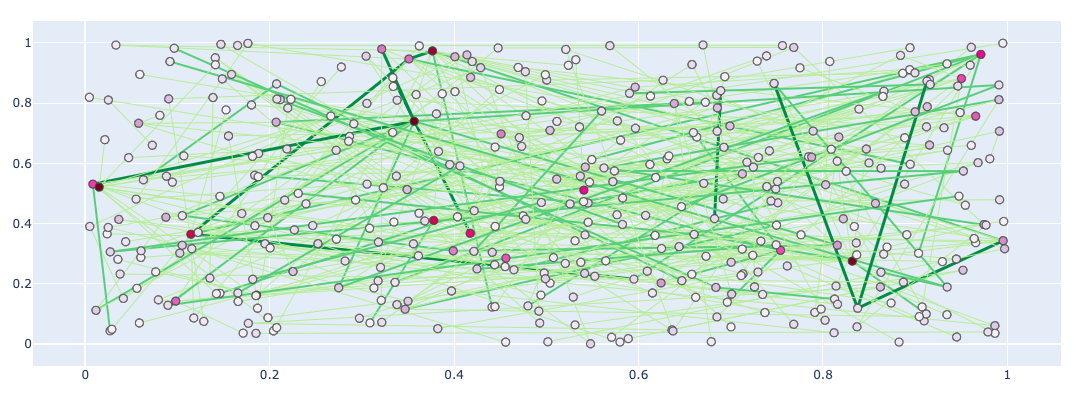

In [77]:
Image('Q4_a1.png')

In [45]:
def plotNetworkSizeColor_Centrality2(graph):
    #closeness centality
    closenessCentr = nx.closeness_centrality(wordpressGraph)
    maxCentr = max(closenessCentr.values())
    minCentr = min(closenessCentr.values())
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=YlGn[edgeWidth]))
        scatters.append(s)

    for node in graph.nodes():
        nodeCentr = closenessCentr[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos],
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=8,
                    line=dict(width=1)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=True)

In [46]:
applyLayout(wordpressGraphRandom, nx.random_layout)
configure_plotly_browser_state()
plotNetworkSizeColor_Centrality2(wordpressGraphRandom)

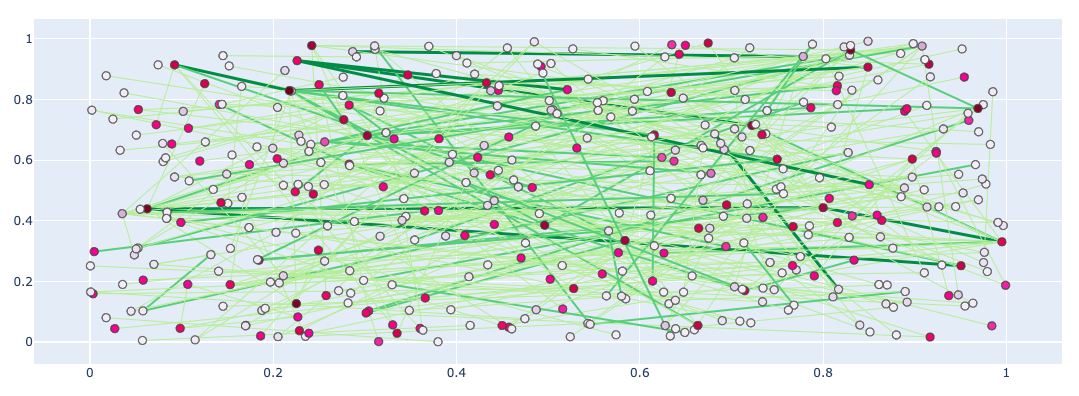

In [78]:
Image('Q4_a2.png')

### (b) List the 5 most central nodes for each of the centrality measures. Discuss the following:
1. Are the results between centrality measures similar or different? Explain a reason for the observed similarity or difference.
2. What centrality measure produced a more meaningful interpretation? Why?

In [47]:
pagerankCentr = nx.pagerank(wordpressGraph)
sorted(pagerankCentr.items(), key=lambda x: x[1], reverse=True)[:5]

[('hashwp', 0.012476128397479613),
 ('bobbyzzzz', 0.012418699555576642),
 ('iheartwordpress', 0.012019030766253876),
 ('hashwordpress', 0.011203878662616872),
 ('area1', 0.00969846097904349)]

In [48]:
closenessCentr = nx.closeness_centrality(wordpressGraph)
sorted(closenessCentr.items(), key=lambda x: x[1], reverse=True)[:5]

[('hashwp', 0.09341073222057487),
 ('area1', 0.09072908440563013),
 ('serjeniu', 0.08944518226781462),
 ('suhd', 0.08902525183463239),
 ('alan_knox', 0.08902525183463239)]

* From above, we can see that the top 5 most central nodes for PageRank centrality and Closeness centrality are kind of different. Although "hashwp" is ranked 1st in both list, and "areal" is also ranked in top 5 in both list, the other results are different. 
* The reason could be the difference of formulation between the two measures. Closeness centrality of a node measures the shortest distance to all other nodes. It is determined by the geodesic distance between nodes at a global level. While the PageRank is a iterative centrality measure which considers the PageRank values from the previous iteration and also the number of in/out degree for the nodes. It basically considers a "neighbourhood" around the node that is being evaluated, instead of all the nodes at the global level. Therefore, the results are different.

* The Closeness centrality produced a more meaningful interpretation. Since PageRank centrality is usually used for the directed graph which takes into account the in/out relationship between nodes. In our case, all the edges are undirected, so the PageRank centrality cannot distinguish the incoming and outgoing edges. While the Closeness centrality takes into account the geodesic distance between nodes, for our case, since it is undirected, the geodesic distance can be measured easily. From the plots we can see that most nodes have very small values of PageRank, and for the Closeness centrality, all the nodes are ranked better since we get different nodes at different centrality values. 

# Q5. Sentiment Analysis

### (a) Using NRCLex, evaluate each tweet and determine the number of words in each dimension of emotion. Construct a chart showing the number of words in each emotion. Which emotion is most frequent in the data? Does that make sense in the context of your chosen hash-tag? Explain why or why not by providing example tweets to support your claims

In [49]:
Cumulative_dict = Counter()
for tweet in wordpressTag['tweet']:
    text_object = NRCLex(tweet)
    absolute_numbers = text_object.raw_emotion_scores
    Cumulative_dict += Counter(absolute_numbers)
    #print(tweet)
    #print(absolute_numbers)
    #print("-"*100)

In [50]:
Cumulative_dict

Counter({'anger': 19,
         'anticipation': 75,
         'disgust': 12,
         'fear': 39,
         'joy': 65,
         'negative': 62,
         'positive': 150,
         'sadness': 38,
         'surprise': 29,
         'trust': 96})

In [51]:
fig = go.Figure()
fig.add_trace(go.Bar(x=list(Cumulative_dict.keys()),
                y=list(Cumulative_dict.values())))
fig.update_layout(
    title_text="Emotion Words Bar Chart",
    xaxis_title_text="Emotion Words",
    yaxis_title_text="Word Count",
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)
fig.show(renderer="colab")

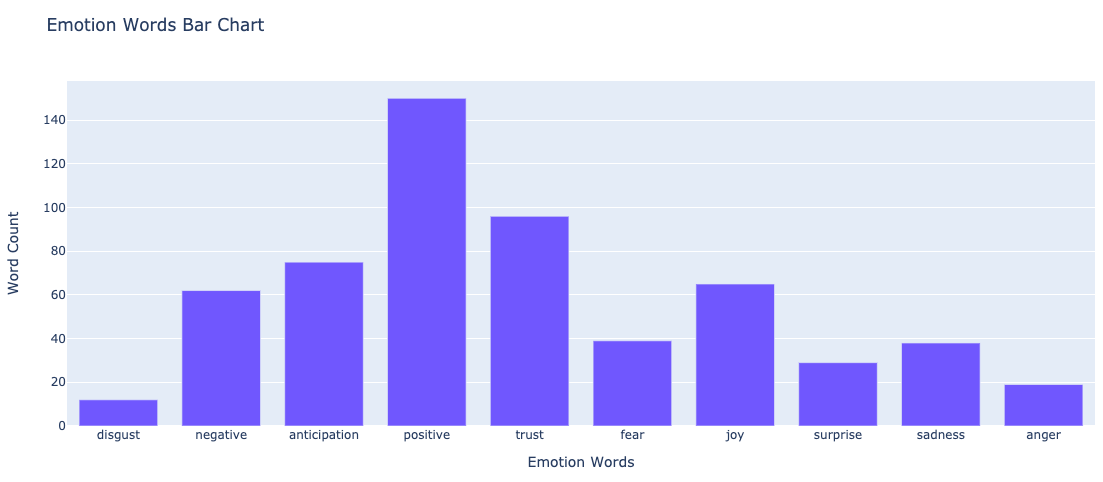

In [79]:
Image('Q5_a.png')

In [67]:
wordpressTag[wordpressTag['user'] == '0lli']

date  ...              mentioned
1474057  2009-06-13 01:05:47  ...  [hashwp, saveforweb)]
2067711  2009-06-13 15:11:29  ...                     []
2495490  2009-06-14 00:42:33  ...      [hashwp, webdis)]
2576951  2009-06-14 02:16:21  ...          [leanne_king]
3141883  2009-06-14 17:14:14  ...  [hashwp, inblogslite]

[5 rows x 4 columns]

* Positive emotion is the most frequent in the data. This makes sense in the context of my chosen hash-tag "wordpress" since in 2009,wordpress became very polular and many people used it to write blogs at that time and it got a lot of positive feedbacks as well. For example, the above tweets were sent by user "0lli". We can see that Wordpress is a free, nice, sleek, stylish and extensive tools which reflect this tool's features and why it was popular at that time.

### (b) For each user, determine which fraction of a user’s total identified words are in each emotional affect (i.e., normalize the counts for each user). Identify the users with the highest fraction of words in each emotion. Note: You may wish to set a minimum number of tweets for user’s to be considered.

In [52]:
#Set minimum number of tweets for a user to be 4. Each user should have at least 4 tweets.
active_user_df = wordpressTag.groupby('user').filter(lambda x : len(x)>=4)
active_user_df.head()

date  ...     mentioned
34534   2009-06-11 17:50:42  ...            []
135206  2009-06-11 20:37:33  ...            []
144543  2009-06-11 20:51:56  ...      [baires]
145360  2009-06-11 20:52:51  ...  [induslogic]
145494  2009-06-11 20:53:03  ...            []

[5 rows x 4 columns]

In [53]:
def getEmotion_byUser(user):
    operation=operator.eq
    stop = set(stopwords.words('english'))
    #counter = Counter()
    tweets = wordpressTag.loc[operation(wordpressTag['user'],user)]['tweet']
    strings = ""
    for tweet in tweets: 
        tweet_noURL = re.sub(r"http\S+", "", tweet)
        strings += (" ".join([word.lower() 
                        for word in re.findall(r'\w+', tweet_noURL)
                        if word.lower() not in stop and len(word) > 2])) + " "
    text_object = NRCLex(strings)
    relative_numbers = text_object.affect_frequencies
    if ("anticip" in relative_numbers) and ("anticipation" not in relative_numbers):
        relative_numbers["anticipation"] = relative_numbers.pop("anticip")
    else:
        relative_numbers.pop('anticip') 
    return relative_numbers

In [54]:
active_user_list = active_user_df.user.unique()
active_user_list

array(['wordpress_work', 'doruman_', 'hashwordpress', 'area1',
       'de_trends2', 'wpdimension', 'iheartwordpress', 'saveforweb',
       'robinmwood', 'spicydesign', 'jonesjj', 'suhd', 'isaacvanname',
       'iniwoonet', 'imjoeperez', 'jonasl', 'mandiengram',
       'blogmarketing', 'textimps', 'justkiddinglife', 'xeduarda', '0lli',
       'minunianda'], dtype=object)

In [55]:
def getHighest_Emotion_User (key):
    fraction_list = []
    for user in active_user_list:
        fraction_list.append(getEmotion_byUser(user)[key])
    max_value = max(fraction_list)
    max_index = fraction_list.index(max_value)
    get_user = active_user_list[max_index]
    return key, get_user, max_value

In [56]:
Emotion_list = []
Highest_fraction_list = []
Emotion_User_list = []
for key in list(Cumulative_dict.keys()):
    Emotion_list.append(getHighest_Emotion_User(key)[0])
    Highest_fraction_list.append(getHighest_Emotion_User(key)[2])
    Emotion_User_list.append(getHighest_Emotion_User(key)[1])
Users_with_highest_emotion_df = pd.DataFrame(list(zip(Emotion_list, Highest_fraction_list, Emotion_User_list)), 
                                             columns =['Emotion', 'Highest_Fraction', 'User'])
Users_with_highest_emotion_df

Emotion  Highest_Fraction             User
0       disgust          0.058824       saveforweb
1      negative          0.250000          jonesjj
2  anticipation          0.368421       imjoeperez
3      positive          0.750000             0lli
4         trust          0.333333      spicydesign
5          fear          0.250000          jonesjj
6           joy          0.333333      spicydesign
7      surprise          0.166667  iheartwordpress
8       sadness          0.250000          jonesjj
9         anger          0.096774         textimps

* The above table shows the users with highest fraction of words in each emotion. To make this analysis effective, I set the minimum number of tweets for each user to be 4. Only users who sent at least 4 tweets with this hash-tag would be considered.

### (c) Construct a plot(s) to answer the following: Is there a correlation between any dimension of emotion and one of the centrality measures you evaluated? If you see a trend, please provide a hypothesis for why; if you do not see a trend, provide a hypothesis for why centrality of a user has no observed correlation with emotion in your particular dataset.


In [57]:
user_list1 = wordpressTag.user.unique() #This is the user names in wordpressTag. length:395
user_list2 = list(wordpressGraph.nodes()) #This is the node names in wordpressGraph, length:413. These names contain the @person as well
final_user_list = list(set(user_list1).intersection(user_list2)) #Take the interception of the two lists, get a list with people who have centrality and sent tweets

In [58]:
def get_centrality(centrality_measure):
    wordpressCentrality = centrality_measure(wordpressGraph)
    centrality_list = []
    for user in final_user_list:
        centrality = wordpressCentrality[user]
        centrality_list.append(centrality)
    return centrality_list

In [59]:
def get_emotion(emotion):
    emotion_list = []
    for user in final_user_list:
        emotionval = getEmotion_byUser(user)[emotion]
        emotion_list.append(emotionval)
    return emotion_list

In [60]:
centrality_list = get_centrality(nx.degree)

In [61]:
Overall_Emotion_list = []
for emotion in Emotion_list:
    Single_Emotion_list = get_emotion(emotion)
    Overall_Emotion_list.append(Single_Emotion_list)

In [63]:
fig = go.Figure()

for i in range (0, len(Emotion_list)): 
    fig.add_trace(go.Scatter(x=Overall_Emotion_list[i], y=centrality_list,
                        mode='markers',
                        name=Emotion_list[i]))

# Set options common to all traces with fig.update_traces
fig.update_layout(title_text="Centrality Vs Emotion Fraction",
                  xaxis_title_text="Emotion Fraction",
                  yaxis_title_text="Centrality")

fig.show(renderer="colab")

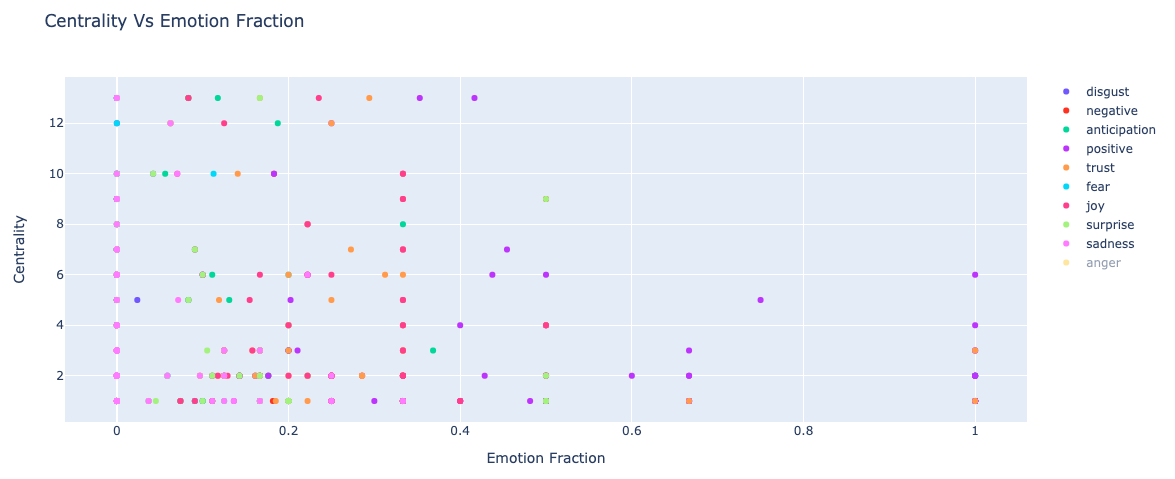

In [80]:
Image('Q5_c1.png')

In [71]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=Overall_Emotion_list[4], y=centrality_list,
                        mode='markers',
                        name=Emotion_list[4]))

# Set options common to all traces with fig.update_traces
fig.update_layout(title_text="Centrality Vs Emotion Fraction",
                  xaxis_title_text="Emotion Fraction",
                  yaxis_title_text="Centrality")

fig.show(renderer="colab")

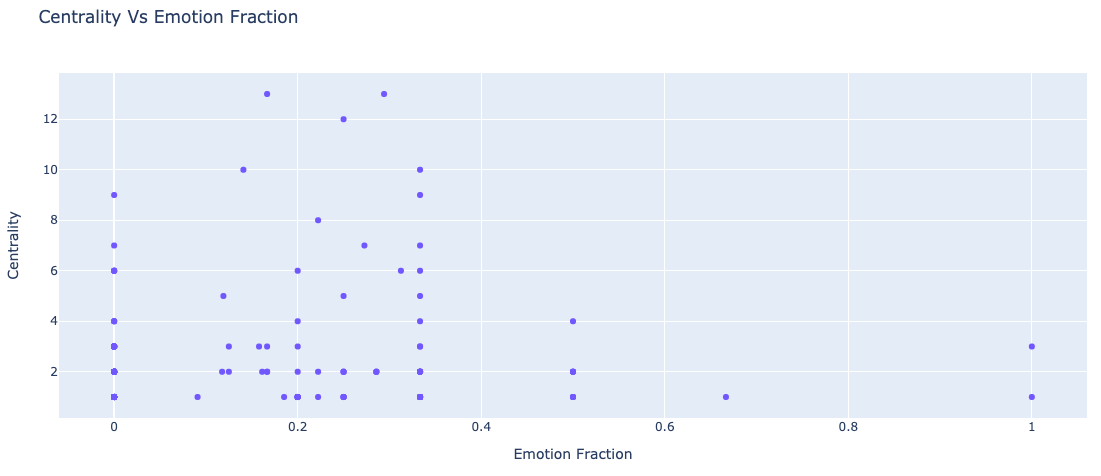

In [81]:
Image('Q5_c2.png')

* The first plot shows the Closeness centrality vs each emotion. Take an example of using the Closeness centrality and the "trust" emotion. There were not obvious trends for the centrality and the emotion. Since we use Closeness centrality, which is measured based on geodesic distance among all the other users. If a user has a high fraction of "trust" emotion, he/she might connects with those who have similar emotion, or have different emotions. Since there are lots of users and they have different emotions so even a user has a "trust" emotion, he/she may not get a high/low Closeness centrality since he/she might be close/far from all other users due to the diversity of emotions that users have.

# Q6

* I completed the user study twice (in 2 different scenarios) on Dec 4 at 5:54pm and 6:21pm using username: stuart.xu@mail.utoronto.ca